<a href="https://colab.research.google.com/github/sweetbaer03/EN_Sentiment-Analysis/blob/main/friends_electra_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FRIENDS Sentiment Analysis**


electra 모델 사용 

In [ ]:
#transformers 설치(colab 사용시)
!pip install transformers

     |████████████████████████████████| 1.4MB 12.9MB/s 
     |████████████████████████████████| 2.9MB 45.8MB/s 
     |████████████████████████████████| 890kB 45.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=23404bea414a17e4a275d5b6878403b0d539763fba7d72394e21cdbe0ecec791
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import tensorflow as tf
import torch
import pandas as pd
import numpy as np
import random
import time
import datetime
import json
import re
import nltk
import matplotlib.pyplot as plt

from transformers import ElectraTokenizer, ElectraForSequenceClassification
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# 데이터처리

github에서 필요한 데이터파일 다운

In [ ]:
!git clone https://github.com/sweetbaer03/EN_Sentiment-Analysis.git

Cloning into 'EN_Sentiment-Analysis'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 11 (delta 1), reused 8 (delta 1), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [ ]:
MAX_LEN = 128 
batch_size = 32
epochs = 20

## 1.1 프렌즈 / 캐글 테스트 데이터

프렌즈 데이터

In [ ]:
def jsonToDf(file_name):
  with open(file_name, encoding = 'utf-8', mode = 'r') as file:
    json_array = json.load(file)
  
  result = pd.DataFrame.from_dict(json_array[0])

  is_first = True
  for array in json_array:
    if is_first:
      is_first = False
      continue
    
    temp_df = pd.DataFrame.from_dict(array)
    result = result.append(temp_df, ignore_index = True)

  return result

In [ ]:
train_data = jsonToDf('EN_Sentiment-Analysis/data_in/friends_train.json')
dev_data   = jsonToDf('EN_Sentiment-Analysis/data_in/friends_dev.json')
test_data  = jsonToDf('EN_Sentiment-Analysis/data_in/friends_test.json')

#train = train.append(dev, ignore_index = True)

In [ ]:
train_data

,speaker,utterance,emotion,annotation
0,Chandler,also I was the point person on my companys tr...,neutral,4100000
1,The Interviewer,You mustve had your hands full.,neutral,5000000
2,Chandler,That I did. That I did.,neutral,5000000
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000
4,Chandler,My duties? All right.,surprise,2000030
...,...,...,...,...
10556,Chandler,You or me?,neutral,3000011
10557,Ross,"I got it. Uh, Joey, women don't have Adam's ap...",non-neutral,2100011
10558,Joey,"You guys are messing with me, right?",surprise,0000050
10559,All,Yeah.,neutral,4000010


In [ ]:
dev_data

,speaker,utterance,emotion,annotation
0,Phoebe,"Oh my God, hes lost it. Hes totally lost it.",non-neutral,0002120
1,Monica,What?,surprise,1000130
2,Ross,"Or! Or, we could go to the bank, close our acc...",neutral,3000200
3,Chandler,Youre a genius!,joy,0500000
4,Joey,"Aww, man, now we wont be bank buddies!",sadness,0040100
...,...,...,...,...
1173,Monica,No.,sadness,2030000
1174,Rachel,What? Oh my God! Im gonna miss you so much!,sadness,0040010
1175,Monica,Im gonna miss you!,sadness,0050000
1176,Rachel,I mean its the end of an era!,sadness,0050000


In [ ]:
test_data

,speaker,utterance,emotion,annotation
0,Mark,Why do all youre coffee mugs have numbers on ...,surprise,2000030
1,Rachel,Oh. Thats so Monica can keep track. That way ...,non-neutral,2100011
2,Rachel,Y'know what?,neutral,3000020
3,Ross,It didnt.,neutral,5000000
4,Frank,"Okay, so what you used to have with Rachel, is...",joy,1300010
...,...,...,...,...
2759,Phoebe,"Hey, why dont you guys go get portraits done ...",neutral,5000000
2760,Monica,Thats a good idea! I bet they have one of tho...,joy,1400000
2761,Phoebe,"Yeah thats great! Next to that, Chandler won...",neutral,3100100
2762,Monica,Chandler what do you say?,neutral,5000000


캐글 테스트 데이터

In [ ]:
test = pd.read_csv('EN_Sentiment-Analysis/data_in/en_data.csv')#, encoding = 'unicode_escape')

In [ ]:
test

,id,i_dialog,i_utterance,speaker,utterance
0,0,0,0,Phoebe,"Alright, whadyou do with him?"
1,1,0,1,Monica,Oh! You're awake!
2,2,0,2,Joey,Then you gotta come clean with Ma! This is not...
3,3,0,3,Mr. Tribbiani,"Yeah, but this is"
4,4,0,4,Joey,I don't wanna hear it! Now go to my room!
...,...,...,...,...,...
1618,1618,150,14,Joey,Nooo.
1619,1619,150,15,Lauren,"Hi, Kate!"
1620,1620,150,16,Kate,"Hi, Lauren."
1621,1621,150,17,Joey,"Hi, Lauren."


### 프랜즈 및 캐글테스트 마스크 처리

프랜즈 데이터 마스크

In [ ]:
print(train_data.shape)
print(dev_data.shape)
print(test_data.shape)
print(test.shape)

(10561, 4)
(1178, 4)
(2764, 4)
(1623, 5)


리뷰의 최대 길이 : 327
리뷰의 평균 길이 : 39.68478363791308


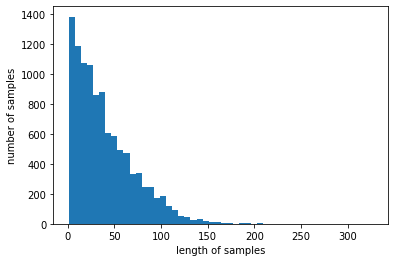

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in train_data['utterance']))
print('리뷰의 평균 길이 :',sum(map(len, train_data['utterance']))/len(train_data['utterance']))
plt.hist([len(s) for s in train_data['utterance']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def cleaning1(str):
    replaceAll= str
    only_english = re.sub('\x92', '\'', replaceAll)
    return only_english

In [ ]:
def getInputsAndLabels(dataset):
  data = dataset.copy(deep=True)
  #data['utterance'] = data['utterance'].str.lower()

  utterances = data['utterance']
  utterances = ["[CLS] " + str(cleaning1(utterance)) + " [SEP]" for utterance in utterances]
  
  encoder = LabelEncoder()
  labels = data['emotion'].values
  encoder.fit(labels)
  labels = encoder.transform(labels)

  tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
  tokenized_texts = [tokenizer.tokenize(utterance) for utterance in utterances]

  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

  attention_masks = []
  for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask)

  return input_ids, labels, attention_masks

In [ ]:
def getInputsFromTest(dataset):
  data = dataset.copy(deep=True)

  utterances = data['utterance']
  utterances = ["[CLS] " + str(cleaning1(utterance)) + " [SEP]" for utterance in utterances]
  
  tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
  tokenized_texts = [tokenizer.tokenize(utterance) for utterance in utterances]

  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

  attention_masks = []
  for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask)

  return input_ids, attention_masks

In [ ]:
def getIndex(dataset):
  data = dataset.copy(deep = True)
  input_index = data.id.tolist()
  return torch.tensor(input_index)

In [ ]:
train_inputs1, train_labels1, train_masks1 = getInputsAndLabels(train_data)
dev_inputs, dev_labels, dev_masks = getInputsAndLabels(dev_data)
test_inputs, test_labels, test_masks = getInputsAndLabels(test_data)
test_inputs1, test_masks1 = getInputsFromTest(test)

In [ ]:
print('전체 프랜즈 학  습 데이터의 개수: {}'.format(len(train_inputs1)))
print('전체 프랜즈 라  벨 데이터의 개수: {}'.format(len(train_labels1)))
print('전체 프랜즈 마스크 데이터의 개수: {}'.format(len(train_masks1)))

전체 프랜즈 학  습 데이터의 개수: 10561
전체 프랜즈 라  벨 데이터의 개수: 10561
전체 프랜즈 마스크 데이터의 개수: 10561


In [ ]:
print('전체 프랜즈 dev학  습 데이터의 개수: {}'.format(len(dev_inputs)))
print('전체 프랜즈 dev라  벨 데이터의 개수: {}'.format(len(dev_labels)))
print('전체 프랜즈 dev마스크 데이터의 개수: {}'.format(len(dev_masks)))

전체 프랜즈 dev학  습 데이터의 개수: 1178
전체 프랜즈 dev라  벨 데이터의 개수: 1178
전체 프랜즈 dev마스크 데이터의 개수: 1178


In [ ]:
print('전체 프랜즈 test학  습 데이터의 개수: {}'.format(len(test_inputs)))
print('전체 프랜즈 test라  벨 데이터의 개수: {}'.format(len(test_labels)))
print('전체 프랜즈 test마스크 데이터의 개수: {}'.format(len(test_masks)))

전체 프랜즈 test학  습 데이터의 개수: 2764
전체 프랜즈 test라  벨 데이터의 개수: 2764
전체 프랜즈 test마스크 데이터의 개수: 2764


In [ ]:
print('전체 프랜즈 test1 학  습 데이터의 개수: {}'.format(len(test_inputs1)))
print('전체 프랜즈 test1 마스크 데이터의 개수: {}'.format(len(test_masks1)))

전체 프랜즈 test1 학  습 데이터의 개수: 1623
전체 프랜즈 test1 마스크 데이터의 개수: 1623


## 1.2 IMDB 데이터

In [ ]:
#IMDB data
train_data2 = pd.read_csv('EN_Sentiment-Analysis/data_in/labeledTrainData.tsv', header = 0, delimiter = '\t', quoting = 3)
train_data2

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."
...,...,...,...
24995,"""3453_3""",0,"""It seems like more consideration has gone int..."
24996,"""5064_1""",0,"""I don't believe they made this film. Complete..."
24997,"""10905_3""",0,"""Guy is a loser. Can't get girls, needs to bui..."
24998,"""10194_3""",0,"""This 30 minute documentary Buñuel made in the..."


In [ ]:
def cleaning_mv(str):
    replaceAll= str
    only_english = re.sub('<br />', '', replaceAll)
    return only_english

# 감정을 숫자로 변환
def emotion_labeling_mv(emotion):
   return{0 : 'angry',1:'joy'}[emotion]

emotion_labels = []

for e in train_data2['sentiment']:
   emotion_labels.append(emotion_labeling_mv(e))

In [ ]:
train_data2['label'] = emotion_labels
train_data2[:10]

,id,sentiment,review,label
0,"""5814_8""",1,"""With all this stuff going down at the moment ...",joy
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ...",joy
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell...",angry
3,"""3630_4""",0,"""It must be assumed that those who praised thi...",angry
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ...",joy
5,"""8196_8""",1,"""I dont know why people think this is such a b...",joy
6,"""7166_2""",0,"""This movie could have been very good, but com...",angry
7,"""10633_1""",0,"""I watched this video at a friend's house. I'm...",angry
8,"""319_1""",0,"""A friend of mine bought this film for £1, and...",angry
9,"""8713_10""",1,"""<br /><br />This movie is full of references....",joy


리뷰의 최대 길이 : 13710
리뷰의 평균 길이 : 1329.71056


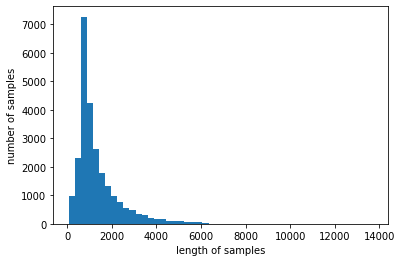

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in train_data2['review']))
print('리뷰의 평균 길이 :',sum(map(len, train_data2['review']))/len(train_data2['review']))
plt.hist([len(s) for s in train_data2['review']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### IMDB 데이터 마스크 처리

In [ ]:
def getInputsAndLabels2(dataset):
  data = dataset.copy(deep=True)

  utterances = data['review']
  utterances = ["[CLS] " + str(cleaning_mv(utterance)) + " [SEP]" for utterance in utterances]
  
  encoder = LabelEncoder()
  labels = data['label'].values
  encoder.fit(labels)
  labels = encoder.transform(labels)

  tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
  tokenized_texts = [tokenizer.tokenize(utterance) for utterance in utterances]

  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

  attention_masks = []
  for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask)

  return input_ids, labels, attention_masks

In [ ]:
train_inputs2, train_labels2, train_masks2 = getInputsAndLabels2(train_data2)

In [ ]:
print('전체 IMDB 학  습 데이터의 개수: {}'.format(len(train_inputs2)))
print('전체 IMDB 라  벨 데이터의 개수: {}'.format(len(train_labels2)))
print('전체 IMDB 마스크 데이터의 개수: {}'.format(len(train_masks2)))

전체 IMDB 학  습 데이터의 개수: 25000
전체 IMDB 라  벨 데이터의 개수: 25000
전체 IMDB 마스크 데이터의 개수: 25000


## 1.3 훈련 데이터 합치기

In [ ]:
train_inputs0 = []
train_inputs0.extend(train_inputs1)
train_inputs0.extend(train_inputs2)

In [ ]:
train_labels0 = []
train_labels0.extend(train_labels1)
train_labels0.extend(train_labels2)

In [ ]:
train_masks0 = []
train_masks0.extend(train_masks1)
train_masks0.extend(train_masks2)

In [ ]:
print('전체 학  습 데이터의 개수: {}'.format(len(train_inputs0)))
print('전체 라  벨 데이터의 개수: {}'.format(len(train_labels0)))
print('전체 마스크 데이터의 개수: {}'.format(len(train_masks0)))

전체 학  습 데이터의 개수: 35561
전체 라  벨 데이터의 개수: 35561
전체 마스크 데이터의 개수: 35561


In [ ]:
train_inputs = torch.tensor(train_inputs0)
train_labels = torch.tensor(train_labels0)
train_masks = torch.tensor(train_masks0)

dev_inputs = torch.tensor(dev_inputs)
dev_labels = torch.tensor(dev_labels)
dev_masks = torch.tensor(dev_masks)

#test_index = getIndex(test)
test_inputs = torch.tensor(test_inputs)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_masks)

test_index1 = getIndex(test)
test_inputs1 = torch.tensor(test_inputs1)
test_masks1 = torch.tensor(test_masks1)

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

dev_data = TensorDataset(dev_inputs, dev_masks, dev_labels)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

test_data1 = TensorDataset(test_index1, test_inputs1, test_masks1)
test_sampler1 = RandomSampler(test_data1)
test_dataloader1 = DataLoader(test_data1, sampler=test_sampler1, batch_size=batch_size)

# 2. 모델 구현

In [ ]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [ ]:
model = ElectraForSequenceClassification.from_pretrained('google/electra-small-generator', num_labels=8)
model.cuda()

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.LayerNorm.weight', 'generator_predictions.LayerNorm.bias', 'generator_predictions.dense.weight', 'generator_predictions.dense.bias', 'generator_lm_head.weight', 'generator_lm_head.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8
                )

total_steps = len(train_dataloader) * epochs

# 학습률을 조금씩 감소시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# 3. 학습


In [ ]:
from sklearn.metrics import f1_score

# 정확도 계산 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def getF1Score(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  return f1_score(labels_flat, pred_flat, average = None)

# 시간 표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
             
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)

        loss = outputs[0]
        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    eval_loss, eval_accuracy, eval_f1 = 0, 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    #for batch in validation_dataloader:
    for batch in dev_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():     
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
     
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        # tmp_eval_f1 = getF1Score(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        # eval_f1 += tmp_eval_f1
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    # print("  F1: {0:.2f}".format(eval_f1/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 20 ========
Training...
  Batch   500  of  1,112.    Elapsed: 0:00:45.
  Batch 1,000  of  1,112.    Elapsed: 0:01:29.

  Average training loss: 0.90
  Training epcoh took: 0:01:39

Running Validation...
  Accuracy: 0.49
  Validation took: 0:00:01

======== Epoch 2 / 20 ========
Training...
  Batch   500  of  1,112.    Elapsed: 0:00:44.
  Batch 1,000  of  1,112.    Elapsed: 0:01:28.

  Average training loss: 0.63
  Training epcoh took: 0:01:38

Running Validation...
  Accuracy: 0.53
  Validation took: 0:00:01

======== Epoch 3 / 20 ========
Training...
  Batch   500  of  1,112.    Elapsed: 0:00:45.
  Batch 1,000  of  1,112.    Elapsed: 0:01:29.

  Average training loss: 0.55
  Training epcoh took: 0:01:39

Running Validation...
  Accuracy: 0.56
  Validation took: 0:00:01

======== Epoch 4 / 20 ========
Training...
  Batch   500  of  1,112.    Elapsed: 0:00:44.
  Batch 1,000  of  1,112.    Elapsed: 0:01:28.

  Average training loss: 0.50
  Training epcoh took: 0:01:38

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))


# f1-score parameter
from sklearn.metrics import f1_score
f1_score_avg = []
trues = []
preds = []

In [ ]:
tmp_test_dataloader = DataLoader(test_data1, sampler=test_sampler1, batch_size=1)
test_result = test.copy(deep = True)
test_result = test_result.drop(columns = ['i_dialog', 'i_utterance', 'speaker'])
test_result['Predicted'] = 'default'
classes = [0,1,2,3,4,5,6,7]

encoder = LabelEncoder()
classes = train['emotion'].values
encoder.fit(classes)
classes = encoder.transform(classes)

#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(tmp_test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(tmp_test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_index, b_input_ids, b_input_mask = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    idx = b_index.item()
    test_result['Predicted'][idx] = encoder.classes_[np.argmax(logits)]
    

    nb_eval_steps += 1

print("")
print("Test took: {:}".format(format_time(time.time() - t0)))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  Batch   100  of  1,623.    Elapsed: 0:00:02.
  Batch   200  of  1,623.    Elapsed: 0:00:03.
  Batch   300  of  1,623.    Elapsed: 0:00:04.
  Batch   400  of  1,623.    Elapsed: 0:00:06.
  Batch   500  of  1,623.    Elapsed: 0:00:07.
  Batch   600  of  1,623.    Elapsed: 0:00:08.
  Batch   700  of  1,623.    Elapsed: 0:00:10.
  Batch   800  of  1,623.    Elapsed: 0:00:11.
  Batch   900  of  1,623.    Elapsed: 0:00:13.
  Batch 1,000  of  1,623.    Elapsed: 0:00:14.
  Batch 1,100  of  1,623.    Elapsed: 0:00:15.
  Batch 1,200  of  1,623.    Elapsed: 0:00:17.
  Batch 1,300  of  1,623.    Elapsed: 0:00:18.
  Batch 1,400  of  1,623.    Elapsed: 0:00:19.
  Batch 1,500  of  1,623.    Elapsed: 0:00:21.
  Batch 1,600  of  1,623.    Elapsed: 0:00:22.

Test took: 0:00:22


In [ ]:
test_result['Predicted']

0           neutral
1          surprise
2       non-neutral
3           neutral
4       non-neutral
           ...     
1618    non-neutral
1619            joy
1620        neutral
1621        neutral
1622    non-neutral
Name: Predicted, Length: 1623, dtype: object

In [ ]:
test_result

,id,utterance,Predicted
0,0,"Alright, whadyou do with him?",neutral
1,1,Oh! You're awake!,surprise
2,2,Then you gotta come clean with Ma! This is not...,non-neutral
3,3,"Yeah, but this is",neutral
4,4,I don't wanna hear it! Now go to my room!,non-neutral
...,...,...,...
1618,1618,Nooo.,non-neutral
1619,1619,"Hi, Kate!",joy
1620,1620,"Hi, Lauren.",neutral
1621,1621,"Hi, Lauren.",neutral


In [ ]:
test_result.drop(labels='utterance', axis="columns", inplace=True)

In [ ]:
DATA_OUT_NAME = "submission_friends_electra_M"+ str(MAX_LEN) + "_B"+ str(batch_size) + "_E"+ str(epochs) + ".csv"

test_csv = test_result.to_csv(DATA_OUT_NAME, columns=['id', 'Predicted'], index=False)
from google.colab import files

files.download(DATA_OUT_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))


# f1-score parameter
from sklearn.metrics import f1_score
f1_score_avg = []
trues = []
preds = []

In [ ]:
#시작 시간 설정
t0 = time.time()
#test_result = test.copy(deep = True)
#test_result = test_result.drop(columns = ['i_dialog', 'i_utterance', 'speaker'])
#test_result['Predicted'] = 'default'

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    #b_index, b_input_ids, b_input_mask = batch
    #b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

   #
    pred_flat = np.argmax(logits, axis=1).flatten()
    trues_flat = label_ids.flatten()
    trues.extend(trues_flat)
    preds.extend(pred_flat)
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  f1 score macro: {0: 2f}".format(f1_score(y_true=trues,y_pred= preds, labels = [0,1,2,3,4,5,6,7], average='macro')))
print("  f1 score micro: {0: 2f}".format(f1_score(y_true=trues, y_pred= preds, labels = [0,1,2,3,4,5,6,7],average='micro')))
print("  f1 score weighted: {0: 2f}".format(f1_score(y_true=trues, y_pred= preds, labels = [0,1,2,3,4,5,6,7],average='weighted')))
print("  f1 score none: {f1_score(y_true=trues, y_pred= preds, labels = [0,1,2,3,4,5,6,7],average=None)}")
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 0.58
  f1 score macro:  0.385057
  f1 score micro:  0.581404
  f1 score weighted:  0.572567
  f1 score none: {f1_score(y_true=trues, y_pred= preds, labels = [0,1,2,3,4,5,6,7],average=None)}
Test took: 0:00:01
